# Can we relate epistatic interactions back to physical interactions?

We'll attempt to answer this question using lattice models. The only physical interactions that exists in the system are contact energies. 

When the native state conformation of the lattice model does not change through sequence space, only 1st and 2nd order epistasis exists (corresponding to changes in contact energies). I show this analytically in physical notebook in lab.

If the native state changes, however, higher order interactions are seen. We believe these interactions are artifacts of a changing coordinate system underneath the model (i.e. a different free energy landscape governing the conformation space). 

The idea in this notebook is to see if we can explain high orer epistasis by ensembles of lower ordered terms. Thus, I'll use nonlinear epistasis model that separates the interactions into separate ensembles for each conformation in sequence space.

In [1]:
%matplotlib inline
import numpy as np
from latticeproteins.sequences import * 
from latticeproteins.conformations import *
from latticegpm.utils import enumerate_space, search_conformation_space
from epistasis.utils import enumerate_space
from latticegpm.utils import search_conformation_space, fold_energy
from latticegpm.space import LatticeConformationSpace
from epistasis.plotting import epistasis_bar, epistasis_barh
from epistasis.models import LocalEpistasisModel
import matplotlib.pyplot as plt
figsize1 = [4,7]
figsize2 = [8,4]

Pre-set sequence spaces to study.

In [2]:
# 6 mutations with two different conformations
s1 = "DIKHLANIMY" 
s2 = "TIPTVANNME"

In [3]:
# 7 mutations with two different conformations
s1 = "FDSAYDPMTV" 
s2 = "WDPSQFHMKV"

In [5]:
# 8 mutations with two different conformations
s1 = "FMHYWDTMTT"
s2 = "FGENYDEFEW"

I use Jesse Bloom's `latticeproteins` python package to enumerate the lattice model conformations and calculate energies.

In [4]:
# build a lattice model
length =10
database_dir = "%s/database" % os.getcwd()
c = Conformations(length, database_dir)
#s1,s2 = search_conformation_space(c, 1.0, 0, differby=8)
#print(s1,s2)

In [5]:
# Calculate the native conformations of the ancestor and derived state.
anc_native = c.FoldSequence(s1, temp=1)
anc_conf = anc_native[1]
der_native = c.FoldSequence(s2, temp=1)
der_conf = der_native[1]
print(anc_conf, der_conf)

URDDDLULU URRDLDLLU


Build a lattice model genotype-phenotype map, folding each sequence to their native conformations.

In [6]:
# build the conformation space.
ss = LatticeConformationSpace(s1, s2, c)
genotypes = ss.sequences
phenotypes = ss.delta_e
ss.print_sequences([s1, s2])

['URDDDLULU' 'URRDLDLLU']
* * * * *
         
* * D-S *
    | |  
* V F A *
  |   |  
* T-M Y *
    | |  
* * P-D *
         
* * * * *
* * * * * *
           
* * D-P-S *
    |   |  
* V W F-Q *
  |   |    
* K-M-H * *
           
* * * * * *


# Results

Classical, high-order, multiplicative epistasis model. We see high order interactions

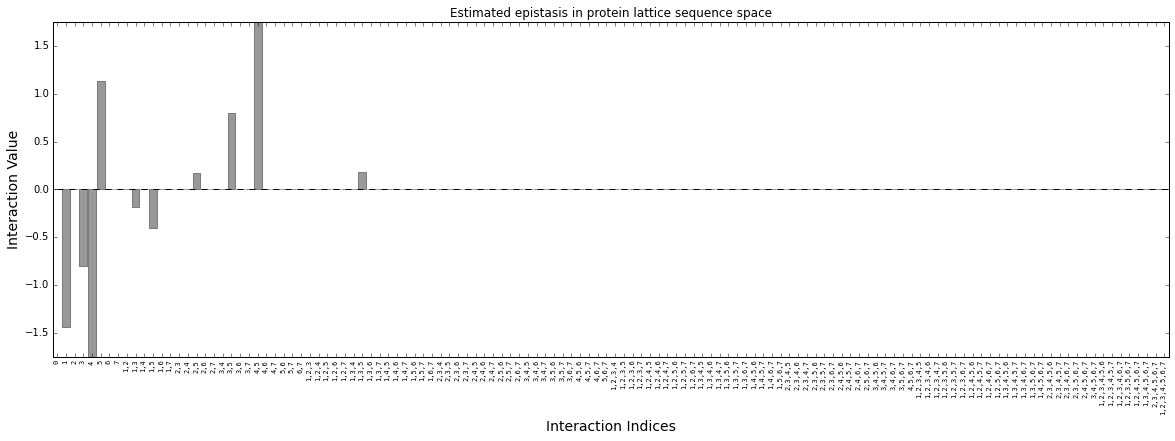

In [7]:
local = LocalEpistasisModel(s1, genotypes, phenotypes)
local.fit()
fig,ax = epistasis_bar(local, string_labels=False, figsize=[20,6], color='k',title="Estimated epistasis in protein lattice sequence space")
#fig.savefig("figures/lattice_epistasis2.png", dpi=300, bbox_inches='tight')

If I force all sequences in the space to single conformation, we see only 2nd order epistasis.

['URDDDLULU']


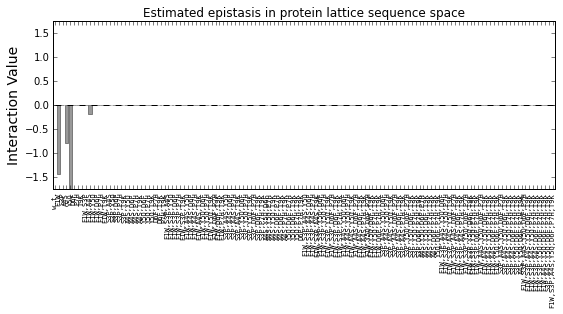

In [8]:
ss = LatticeConformationSpace(s1, s2, c, target_conf=anc_conf)
genotypes = ss.sequences
phenotypes = ss.delta_e
local = LocalEpistasisModel(s1, genotypes, phenotypes)
local.fit()
fig,ax = epistasis_bar(local, string_labels=True, figsize=[9,3], 
                       color='k',title="Estimated epistasis in protein lattice sequence space")
#fig.savefig("figures/lattice_epistasis_conf2.png", dpi=300, bbox_inches='tight')

## Build a two state, nonlinear epistasis model

In [9]:
from epistasis.utils import build_interaction_labels, label_to_key
from epistasis.models import NonlinearEpistasisModel
from epistasis.regression_ext import generate_dv_matrix

Name two sets of parameters for epistasis to describe each set of conformations.

In [38]:
from collections import OrderedDict # use this to order params

A_labels = build_interaction_labels(7,2)
A_keys = [label_to_key(i, state="A") for i in A_labels]
B_labels = build_interaction_labels(7,2)
B_keys = [label_to_key(i, state="B") for i in B_labels]

params = OrderedDict(zip(A_keys + B_keys, A_labels + B_labels))

Build a custom two state ensemble model function.

In [39]:
def two_state_func(x, *args):
    """ Two state boltzmann weighted nonlinear function."""
    beta = args[-1]
    params = args[:-1]
    length = len(params)
    params1 = np.array(params[0:int(length/2)])
    params2 = np.array(params[int(length/2):])
    X1 = np.exp(-np.dot(x[0:int(length/2),:].T, params1)/beta)
    X2 = np.exp(-np.dot(x[int(length/2):-1,:].T, params2)/beta)
    return -beta*np.log(X1 + X2)

Build the data-structure for the fit (i.e. a dummy variable matrix, X)

In [40]:
# Build dummy variable matrix for nonlinear model.
xdata = generate_dv_matrix(genotypes, list(params.values()))

# Add column for temperature to parameters and dummy matrix
params['temperature'] = [100]
xdata = np.concatenate((xdata, np.array([np.ones(len(phenotypes))]).T), axis=1)
print(params)

OrderedDict([('0A', [0]), ('1A', [1]), ('2A', [2]), ('3A', [3]), ('4A', [4]), ('5A', [5]), ('6A', [6]), ('7A', [7]), ('1,2A', [1, 2]), ('1,3A', [1, 3]), ('1,4A', [1, 4]), ('1,5A', [1, 5]), ('1,6A', [1, 6]), ('1,7A', [1, 7]), ('2,3A', [2, 3]), ('2,4A', [2, 4]), ('2,5A', [2, 5]), ('2,6A', [2, 6]), ('2,7A', [2, 7]), ('3,4A', [3, 4]), ('3,5A', [3, 5]), ('3,6A', [3, 6]), ('3,7A', [3, 7]), ('4,5A', [4, 5]), ('4,6A', [4, 6]), ('4,7A', [4, 7]), ('5,6A', [5, 6]), ('5,7A', [5, 7]), ('6,7A', [6, 7]), ('0B', [0]), ('1B', [1]), ('2B', [2]), ('3B', [3]), ('4B', [4]), ('5B', [5]), ('6B', [6]), ('7B', [7]), ('1,2B', [1, 2]), ('1,3B', [1, 3]), ('1,4B', [1, 4]), ('1,5B', [1, 5]), ('1,6B', [1, 6]), ('1,7B', [1, 7]), ('2,3B', [2, 3]), ('2,4B', [2, 4]), ('2,5B', [2, 5]), ('2,6B', [2, 6]), ('2,7B', [2, 7]), ('3,4B', [3, 4]), ('3,5B', [3, 5]), ('3,6B', [3, 6]), ('3,7B', [3, 7]), ('4,5B', [4, 5]), ('4,6B', [4, 6]), ('4,7B', [4, 7]), ('5,6B', [5, 6]), ('5,7B', [5, 7]), ('6,7B', [6, 7]), ('temperature', [100])]

Results of the two state model: 

/Users/Zsailer/virtual/py3/lib/python3.4/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(<matplotlib.figure.Figure at 0x10b544e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10b5f3748>)

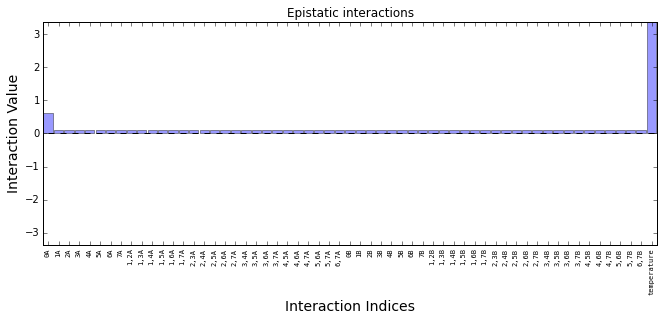

In [41]:
# Create an instance of the model and fit as normal.
model = NonlinearEpistasisModel(s1, 
                                genotypes, 
                                phenotypes, 
                                two_state_func, 
                                xdata,
                                params)

model.fit()
epistasis_bar(model, string_labels=False, figsize=[11,4])

# Conclusions

This idea did not work the way we thought -- we believe this is due to numerical issues in the nonlinear fit. Small numbers and exponentials do not play nicely. 

Analytically, we can show that lattice models should only display 2nd order epistasis; though, these interactions are difficult to explain in terms of the underlying physics. Each epistatic parameter may be the manifestation of multiple contact energies folded into a single term. It's impossible to tease this apart without knowing everything about the physics of the system. This is, obviously, impractical for real systems.